In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random

In [2]:
def load_data():
    data = np.genfromtxt(os.getcwd() + '/dataCircle.csv', delimiter=',')
    pos = data[np.where(data[:, 2] == 1)]
    neg = data[np.where(data[:, 2] == -1)]
    return (pos, neg, data)

pos, neg, data = load_data()

In [3]:
def plot_data(pos, neg):
    fig, ax = plt.subplots(1)
    ax.plot(pos[:, 0], pos[:, 1], '.', c='green')
    ax.plot(neg[:, 0], neg[:, 1], '.', c='red')
    return fig, ax

In [4]:
class Evaluation:
    
    def __init__(self, trueLabel = 'p', falseLabel = 'n'):
        self.tp = []
        self.tn = []
        self.fp = []
        self.fn = []
        self.trueLabel = trueLabel
        self.falseLabel = falseLabel
        self.total = 0
        
    def add(self, pred, label):
        if pred != self.trueLabel and pred != self.falseLabel or label != self.trueLabel and label != self.falseLabel:
            print("Error! Prediction and Label have to be either '"
                  + str(self.trueLabel) +"' or '"+str(self.falseLabel)+"' !")
            return
        
        if pred == label:
            if pred == self.trueLabel:
                self.tp.append((pred, label))
            if pred == self.falseLabel:
                self.tn.append((pred, label))
        if pred != label:
            if pred == self.trueLabel:
                self.fp.append((pred, label))
            if pred == self.falseLabel:
                self.fn.append((pred, label))
        self.total += 1
        
    def acc(self, v = True):
        trues = len(self.tp) + len(self.tn)
        acc = trues / self.total
        if v:
            print("Accuracy: %i / %i -> %f" % (trues, self.total, acc))
        return acc
    
    def prec(self, v = True):
        pred_pos = (len(self.tp) + len(self.fp))
        prec = len(self.tp) / pred_pos
        if v:
            print("Precision: %i / %i -> %f" % (len(self.tp), pred_pos, prec))
        return prec
    
    def rec(self, v = True):
        cond_pos = (len(self.tp) + len(self.fn))
        rec = len(self.tp) / cond_pos
        if v:
            print("Recall: %i / %i -> %f" % (len(self.tp), cond_pos, rec))
        return rec
    
    def f1(self, v = True):
        rec = self.rec(False)
        prec = self.prec(False)
        f1 = 2 * prec * rec / (prec + rec)
        if v:
            print("F1: %f" % (f1))
        return f1
    
    def print_summary(self):
        self.acc(True)
        self.prec(True)
        self.rec(True)
        self.f1(True)
        

In [5]:
def init_distribution(data):
    d1 = np.ones(data.shape[0], dtype=np.float128)
    d1 /= len(data)
    
    assert np.isclose(np.sum(d1), 1.0)
    return d1

d1 = init_distribution(data)

In [6]:
class weak_classifier:
    def __init__(self, minn=-10., maxx=-10., axis='x', prec=0.1):
        self.minn = minn
        self.maxx = maxx
        f = 1 / prec
        self.theta = random.randrange(-10 *f , 10*f, 0.1*f)/f
        self.axis = axis
        
    def __str__(self):
        return "{%s %.2f}" % (self.axis, self.theta)
    
    def __repr__(self):
        return "{%s %.2f}" % (self.axis, self.theta)
    
    def pred(self, x, y):
        if self.axis =='x1':
            return 1 if x > self.theta else -1
        elif self.axis =='x2':
            return 1 if x < self.theta else -1
        elif self.axis =='y1':
            return 1 if y > self.theta else -1
        elif self.axis =='y2':
            return 1 if y < self.theta else -1
        
    def kronecker(self, x, y, label):
        return 1 if self.pred(x, y) != label else 0
    
    def plot(self, ax = None, a=1.):
        plt.xlim(self.minn, self.maxx)
        plt.ylim(self.minn, self.maxx)
        fig = None
        if ax == None:
            fig, ax = plt.subplots(1)
        if 'x' in self.axis:
            ax.axhline(self.theta, linewidth=5 * a, alpha=a)
        else:
            ax.axvline(self.theta, linewidth=5 * a, alpha=a)
            
class strong_classifier:
    def __init__(self, ats, hts):
        assert len(ats) == len(hts)
        self.ats = ats
        self.hts = hts        
        
    def pred(self, x, y):
        F = 0
        for at, ht in zip(ats, hts):
            F += at * ht.pred(x, y)
        return np.sign(F)
        
        
    def plot_all(self, ax = None):
        fig = None
        if ax == None:
            fig, ax = plt.subplots(1)
        for at, ht in zip(ats, hts):
            ht.plot(ax, at)
            
    def __len__(self):
        return len(ats)

In [7]:
def generate_weak_classifiers(minn=-10, maxx=10., n=20):
    # generate lines parallel to the x or y axis as weak classifiers
    hts = []
    for i in range(n // 4):
        hts.append(weak_classifier(minn, maxx, 'x1')) # parallel to x axis
    
    for i in range(n // 4):
        hts.append(weak_classifier(minn, maxx, 'x2')) # parallel to x axis
    
    for i in range(n // 4):
        hts.append(weak_classifier(minn, maxx, 'y1')) # parallel to x axis
    
    for i in range(n // 4):
        hts.append(weak_classifier(minn, maxx, 'y2')) # parallel to x axis
    
    
    return hts

In [8]:
def compute_weighted_errors(hts, distr, data):
    # compute weighted errors for all weak classifiers
    ets = []
    for h in hts:
        e = 0
        for i, p in enumerate(data):
            x, y, label = p[0], p[1], p[2]
            e += distr[i] * h.kronecker(x, y, label)
        assert e >= 0 and e <= 1.0
        ets.append(e)
    
    return ets

def select_weak_classifier(hts, errors_t):
    # select weak classifier with minimum error
    return hts[np.argmin(errors_t)], np.min(errors_t)

def compute_alpha_t(error_t):
    return 0.5 * np.log((1-error_t)/(error_t))

def compute_zt(distr_t, alpha_t, ht, data):
    zt = 0
    for i, d in enumerate(data):
        zt += distr_t[i] * np.exp(-alpha_t * d[2] * ht.pred(d[0], d[1]))
    return zt

def update_distribution(distr_t, alpha_t, zt, ht, data):
    assert np.isclose(np.sum(distr_t), 1.0)
    distr_t1 = np.zeros_like(distr_t)
    zt = 0
    for i, d in enumerate(data):
        x = distr_t[i] * np.exp(-alpha_t * d[2] * ht.pred(d[0], d[1]))
        zt += x
        distr_t1[i] = x
    distr_t1 /= zt
        
    assert np.isclose(np.sum(distr_t1), 1.0)
    return distr_t1

In [9]:
# load the data
pos, neg, data = load_data()

# initialize the distribution for the first timestep 
distr = init_distribution(data)

# generate N weak classifiers
N = 250
#random.seed(42)
h = generate_weak_classifiers(n=N)

# train adaboos for T timesteps
T = 100
ats = []
ets = []
hts = []
distrs = []
distrs.append(distr)
for t in range(T):
    # 1. Learn weak classifier ht using distribution Dt
    errors_t = compute_weighted_errors(h, distr, data)
    # for e in errors_t:
    #    print(e)
    ht, et = select_weak_classifier(h, errors_t)
    # print(et)
    # print(ht)
    # 2. Set weight αt based on the error
    at = compute_alpha_t(et)
    # 3. Update the distribution based on the performance so far
    zt = compute_zt(distr, at, ht, data)
    distr = update_distribution(distr, at, zt, ht, data)
    # collect results
    distrs.append(distr)
    ats.append(at)
    hts.append(ht)
    ets.append(et)
    

Accuracy: 102 / 102 -> 1.000000
Precision: 40 / 40 -> 1.000000
Recall: 40 / 40 -> 1.000000
F1: 1.000000


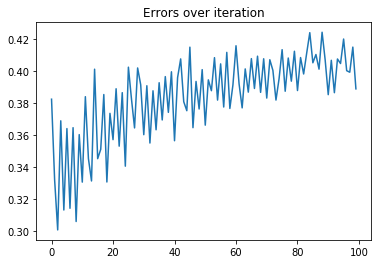

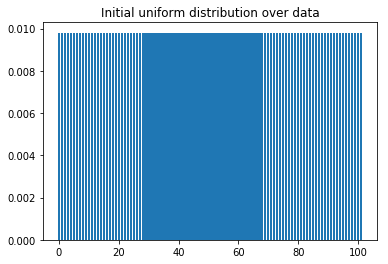

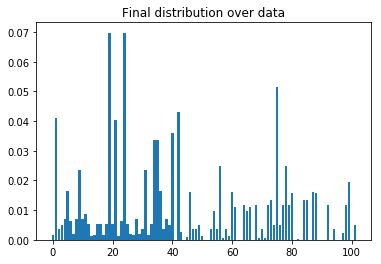

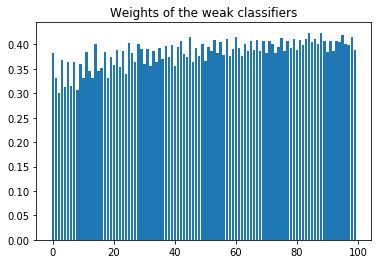

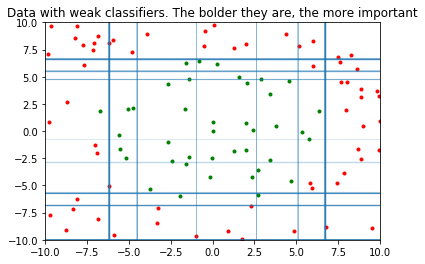

In [10]:
fig, ax = plt.subplots(1)
ax.plot(np.arange(T), np.array(ets))
ax.set(title='Errors over iteration')

fig, ax = plt.subplots(1)
ax.bar(np.arange(len(data)), distrs[0], linewidth=.25)
ax.set(title='Initial uniform distribution over data')

fig, ax = plt.subplots(1)
ax.bar(np.arange(len(data)), distrs[-1], linewidth=.25)
ax.set(title='Final distribution over data')

fig, ax = plt.subplots(1)
ax.bar(np.arange(len(ets)), ets)
ax.set(title='Weights of the weak classifiers')

H = strong_classifier(ats, hts)
fig, ax = plot_data(pos, neg)
H.plot_all(ax)
ax.set(title='Data with weak classifiers. The bolder they are, the more important')




evaluation = Evaluation(1, -1)
for d in data:
    pred = H.pred(d[0], d[1])
    evaluation.add(pred, d[2])
    if pred != d[2]:
        print("(%i, %i)\t-> Label: %i Prediction: %i \n" % (d[0], d[1], d[2], pred))
        ax.plot(d[0], d[1], 'o', c='black', linewidth=4)

evaluation.print_summary()